In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

# # 사용할 피처 선택 (customer_id 제거)
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [2]:
from sklearn.metrics import roc_curve, auc

def auc_plot(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
# log1p 변환 수행
skewed_columns = ['age', 'balance', 'estimated_salary', 'credit_score']

for column in skewed_columns:
    df[column] = df[column].apply(np.log1p)
    
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,6.429719,0,1,3.761200,2,0.000000,1,1,1,11.526334,1
1,6.411818,2,1,3.737670,1,11.336294,1,0,1,11.631096,0
2,6.220590,0,1,3.761200,8,11.980813,3,1,0,11.643362,1
3,6.551080,0,1,3.688879,1,0.000000,2,0,0,11.449215,0
4,6.746412,2,1,3.784190,2,11.740155,1,1,1,11.278280,0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = StandardScaler()

X = df[features]
y = df['churn']

X = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
# from catboost import CatBoostClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier

# 데이터 준비
# X = df.drop(columns=['churn'])
# y = df['churn']


# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 🎯 **하이퍼파라미터 최적화 (Optuna)**
def objective(trial):
    params = {
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 3),  # 이탈 고객 비율 증가
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42
    }
    
    # 모델 학습
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    # 예측 확률
    y_probs = model.predict_proba(X_test)[:, 1]

    # AUC 평가 기준
    return roc_auc_score(y_test, y_probs)

# **Optuna 실행**
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

study.best_params

/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-12 17:49:33,641] A new study created in memory with name: no-name-5d186c18-a267-4dae-8022-94e9182f97a2
/opt/anaconda3/envs/pystudy_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:49:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-12 17:49:33,752] Trial 0 finished with value: 0.859030649889462 and parameters: {'colsample_bytree': 0.5167126562911918, 'learning_rate': 0.07288541484736413, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 125, 'subsample': 0.539647185388225, 'scale_pos_weight': 2.904603108679968}. Best is trial 0 with value: 0.859030649889462.
/opt/anaconda3

{'colsample_bytree': 0.8142361431509895,
 'learning_rate': 0.03993476038358372,
 'max_depth': 3,
 'min_child_weight': 6,
 'n_estimators': 155,
 'subsample': 0.7904294045916995,
 'scale_pos_weight': 1.6252985731703875}

In [6]:
# %pip install catboost

In [7]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ada_best_params = {
    'learning_rate': 1, 
    'n_estimators': 450
}

ada_best_params = {
    'n_estimators': 297, 
    'learning_rate': 0.29436353114378083
}

ada = AdaBoostClassifier(random_state=42, **ada_best_params)

cat_best_params = {
    'depth': 4, 
    'iterations': 100, 
    'learning_rate': 0.1
}
cat_best_params = {
    'iterations': 938,
    'depth': 4,
    'learning_rate': 0.04029667375026597,
    'random_strength': 62,
    'bagging_temperature': 1.0589520689603074,
    'od_type': 'Iter',
    'od_wait': 49,
    'l2_leaf_reg': 606.8679965211409,
    'border_count': 247
}
cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 2.21])
# cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 50])

xgb_best_params = {
'colsample_bytree': 0.998835926756326,
    'learning_rate': 0.05918736154295684,
    'max_depth': 4,
    'min_child_weight': 4,
    'n_estimators': 152,
    'subsample': 0.7171956369176462,
    'scale_pos_weight': 1.9,  # Recall 최적화된 비율
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}
xgb = XGBClassifier(random_state=42, **xgb_best_params)

rf_best_params = {
    'n_estimators':200, 
    'max_depth':15, 
    'min_samples_leaf':2, 
    'min_samples_split':5
}
rf_best_params = {'n_estimators': 153,
    'max_depth': 6,
    'min_samples_split': 6,
    'min_samples_leaf': 2,
    'max_features': 3
}
rf = RandomForestClassifier(random_state=42, **rf_best_params, verbose=0)

In [8]:
# import optuna

# def objective(trial):
#     # AdaBoostClassifier
#     ada_params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1)
#     }
#     ada = AdaBoostClassifier(random_state=42, **ada_params)
    
#     # CatBoostClassifier
#     cat_params = {
#         'depth': trial.suggest_int('depth', 4, 10),
#         'iterations': trial.suggest_int('iterations', 100, 500),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1)
#     }
#     cat = CatBoostClassifier(random_state=42, **cat_params, verbose=0, class_weights=[1, 2.21])
    
#     # XGBClassifier
#     xgb_params = {
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'subsample': trial.suggest_uniform('subsample', 0.1, 1),
#         'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 2),
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss'
#     }
#     xgb = XGBClassifier(random_state=42, **xgb_params)
    
#     # RandomForestClassifier
#     rf_params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
#     }
#     rf = RandomForestClassifier(random_state=42, **rf_params, verbose=0)
    
#     models = [ada, cat, xgb, rf]
#     model_names = ['AdaBoost', 'CatBoost', 'XGBoost', 'RandomForest']
    
#     best_score = 0
    
#     for model, model_name in zip(models, model_names):
#         model.fit(X_train, y_train)
#         score = model.score(X_test, y_test)
        
#         if score > best_score:
#             best_score = score
            
#     return best_score

# study = optuna.create_study(direction='maximize')

# study.optimize(objective, n_trials=100)

# study.best_params

# study.best_value

# study.trials_dataframe()

              precision    recall  f1-score   support

           0     0.9054    0.9012    0.9033      2389
           1     0.6206    0.6318    0.6261       611

    accuracy                         0.8463      3000
   macro avg     0.7630    0.7665    0.7647      3000
weighted avg     0.8474    0.8463    0.8468      3000



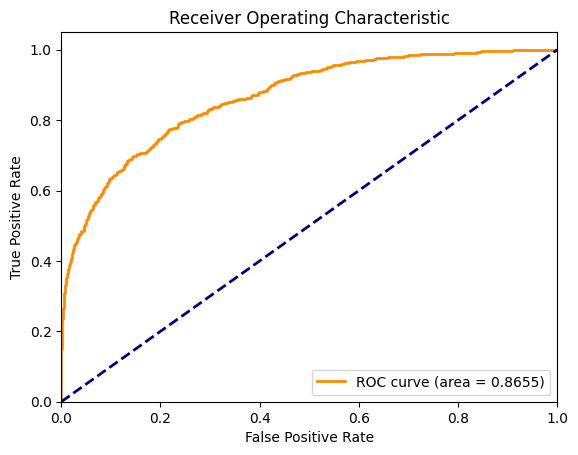

In [9]:
from sklearn.metrics import classification_report

cat.fit(X_train, y_train)

# 모델 평가
y_pred = cat.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(cat, X_test, y_test)

              precision    recall  f1-score   support

           0     0.8843    0.9468    0.9145      2389
           1     0.7127    0.5155    0.5983       611

    accuracy                         0.8590      3000
   macro avg     0.7985    0.7312    0.7564      3000
weighted avg     0.8493    0.8590    0.8501      3000



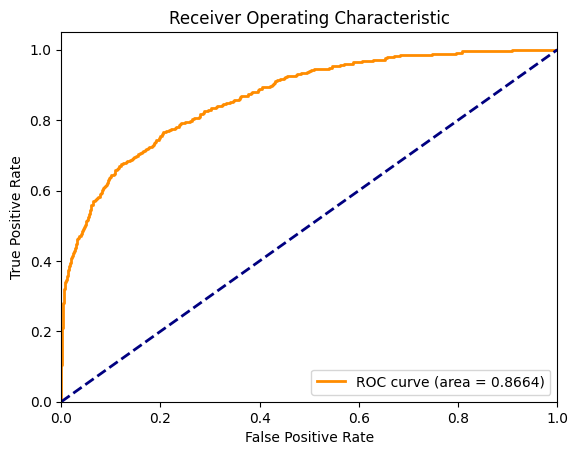

In [10]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf),
    ('ada', ada)
]

voting = VotingClassifier(estimators=estimators, voting='soft')

voting.fit(X_train, y_train)

y_pred = voting.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(voting, X_test, y_test)

              precision    recall  f1-score   support

           0     0.9036    0.9104    0.9070      2389
           1     0.6391    0.6203    0.6296       611

    accuracy                         0.8513      3000
   macro avg     0.7714    0.7654    0.7683      3000
weighted avg     0.8497    0.8513    0.8505      3000



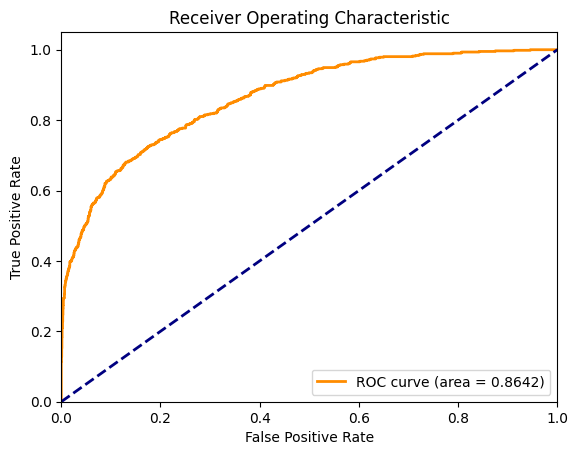

In [11]:
from itertools import permutations
from sklearn.ensemble import StackingClassifier

perms = list(map(list, permutations(estimators)))

estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('ada', ada),
    ('cat', cat),
]

# for perm in perms:
stacking = StackingClassifier(estimators=estimators, final_estimator=cat, cv=5)

stacking.fit(X_train, y_train)

y_pred = stacking.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(stacking, X_test, y_test)

In [12]:
from joblib import dump

dump(stacking, './model/stacking.joblib')

['./model/stacking.joblib']